# Import Data

In [46]:
import pandas as pd
pd.set_option('display.max_columns', None)

import joblib # To save classifier objects from crashing kernels.... :(

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import HistGradientBoostingClassifier, IsolationForest

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from catboost import CatBoostClassifier

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

In [47]:
def output_report(name, best_score, best_params):
    print(f'Report: {name}\nBest F1_Makro: {best_score}\nBest Params: {best_params}')

In [48]:
df = pd.read_parquet('../data/train_val_data.parquet', engine='fastparquet')
df_test = pd.read_parquet('../data/test_data.parquet', engine='fastparquet')

## Select & Clean up Columns

In [49]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 
    'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 
    'age',
]

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 
]

In [50]:
for x in [df, df_test]:
    # Encode Na Values -----------------------------------

    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)  
    x[x.columns.difference(na_with_meaning)] = x[x.columns.difference(na_with_meaning)].replace(-1, pd.NA)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    
    x.dropna(inplace=True)
    # Data Cleanup ---------------------------------------

In [51]:
categorical_unordered = ['location', 'type_of_collision', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position', 'sex', 
                         'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
                         'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 
                         'motor_type_other', 'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 
                         'surface_quality_indicator', 'role', 'cluster']

categorical_ordered = {
    'time_of_day': pd.CategoricalDtype(['Morning_Rush', 'Midday', 'Evening_Rush', 'Night'], ordered=True),
    'day_of_week': pd.CategoricalDtype([0,1,2,3,4,5,6], ordered=True),
    'age_group': pd.CategoricalDtype(['Unknown', 'child_teen', 'young_adult', 'adult', 'middle_aged', 'senior'], ordered=True),
    'lighting_ordinal': pd.CategoricalDtype([0,1,2,3], ordered=True),
    'weather_ordinal': pd.CategoricalDtype([0,1,2,3,4], ordered=True),
    'injury_target': pd.CategoricalDtype([0,1,2], ordered=True),
    'reserved_lane_present': pd.CategoricalDtype(ordered=True),
    'impact_score': pd.CategoricalDtype(ordered=True),
    'impact_score_other': pd.CategoricalDtype(ordered=True),
    'impact_delta': pd.CategoricalDtype(ordered=True)
}

numeric = ['speed_limit']

df[categorical_unordered] = df[categorical_unordered].astype('category')
df_test[categorical_unordered] = df_test[categorical_unordered].astype('category')

df = df.astype(categorical_ordered)
df_test = df_test.astype(categorical_ordered)

df[numeric] = df[numeric].astype('int16')
df_test[numeric] = df_test[numeric].astype('int16')

## Split Train and Test Data

In [52]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

## Remove Outliers

In [53]:
cat_idx = [i for i, (col, dt) in enumerate(X_train.dtypes.items())
           if isinstance(dt, pd.CategoricalDtype)]

# 1) Build a numeric view of X_train for IsolationForest
cat_cols = [c for c in X_train.columns if isinstance(X_train[c].dtype, pd.CategoricalDtype)]
num_cols = [c for c in X_train.columns if c not in cat_cols]

iso_transformer = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

X_train_iso = iso_transformer.fit_transform(X_train)

# 2) Isolation Forest on the numeric representation
pruner = IsolationForest(n_jobs=-1, random_state=42, n_estimators=1000)
mask = pruner.fit_predict(X_train_iso)   # 1 = inlier, -1 = outlier
inlier_mask = (mask == 1)

# Use the mask on the *original* X_train / y_train
X_train, y_train = X_train[inlier_mask], y_train[inlier_mask]

## Rebalance the Data

In [54]:
under_sampler = RandomUnderSampler(random_state=42, sampling_strategy='not minority')

X_train_rebalanced, y_train_rebalanced = under_sampler.fit_resample(X_train, y_train)
X_train_unbalanced, y_train_unbalanced = X_train, y_train
X_train, y_train = None, None # Reset to avoid mixups

# Models

In [55]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Ridge Classifier

### Hyperparameter Tuning

In [76]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']
num_cols = ['speed_limit', 'road_complexity_index']

transformer_ridge = ColumnTransformer([
    # OneHotEncode all categorical columns to avoid ordinal leakage
    ('cat_unordered', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_unordered),
    ('cat_ordered', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline_ridge = Pipeline(steps=[
    ('transform', transformer_ridge),
    ('classifier', RidgeClassifierCV(alphas=[0.05*x for x in range(1, 101)], scoring='f1_macro', cv=cv))
])

In [77]:
pipeline_ridge.fit(X_train_rebalanced, y_train_rebalanced)

,steps,"[('transform', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat_unordered', ...), ('cat_ordered', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [78]:
print('Ridge Classifier Validation Set Report:')
print(f'Best Makro-F1: {pipeline_ridge["classifier"].best_score_}')
print(f'Alpha: {pipeline_ridge["classifier"].alpha_}')

Ridge Classifier Validation Set Report:
Best Makro-F1: 0.65452537667008
Alpha: 1.5


### Cross Validation Score

In [79]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']
num_cols = ['speed_limit', 'road_complexity_index']

transformer_ridge = ColumnTransformer([
    # OneHotEncode all categorical columns to avoid ordinal leakage
    ('cat_unordered', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_unordered),
    ('cat_ordered', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline_ridge = Pipeline(steps=[
    ('transform', transformer_ridge),
    ('classifier', RidgeClassifier(alpha=1.5))
])

              precision    recall  f1-score   support

           0       0.78      0.71      0.74     53605
           1       0.56      0.51      0.53     53605
           2       0.64      0.75      0.69     53605

    accuracy                           0.66    160815
   macro avg       0.66      0.66      0.65    160815
weighted avg       0.66      0.66      0.65    160815



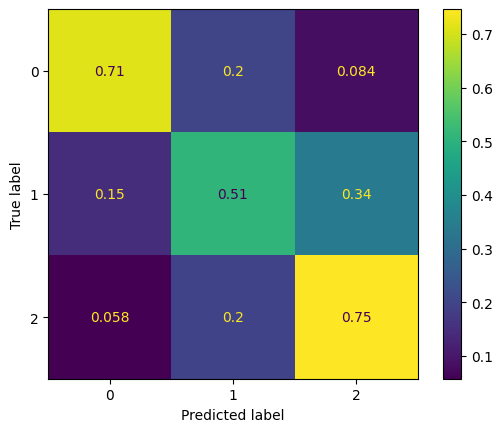

In [80]:
y_pred_ridge = cross_val_predict(pipeline_ridge, X_train_rebalanced, y_train_rebalanced, cv=cv, n_jobs=-1)

print(classification_report(y_train_rebalanced, y_pred_ridge))
ConfusionMatrixDisplay(confusion_matrix(y_train_rebalanced, y_pred_ridge, normalize='true')).plot()

### Generalization Performance

              precision    recall  f1-score   support

           0       0.84      0.72      0.78     51051
           1       0.59      0.46      0.52     39476
           2       0.40      0.77      0.53     17440

    accuracy                           0.63    107967
   macro avg       0.61      0.65      0.61    107967
weighted avg       0.68      0.63      0.64    107967



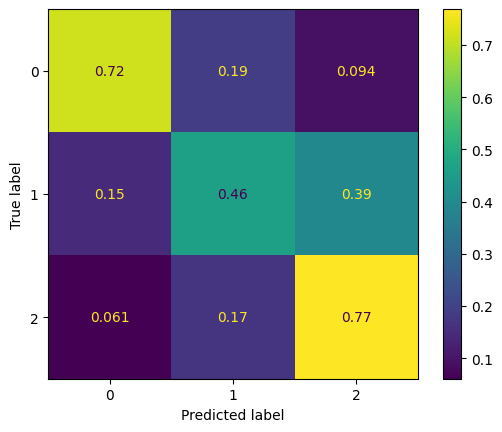

In [81]:
pipeline_ridge.fit(X_train_rebalanced, y_train_rebalanced)
y_pred = pipeline_ridge.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

## BalancedRandomForestClassifier

### Hyperparameter Tuning

In [18]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']

transformer_random_forest = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'), ord_cols + categorical_unordered),
], remainder='passthrough')

pipeline_balanced_random_forest = Pipeline(steps=[
    ('transformer', transformer_random_forest),
    ('classifier', BalancedRandomForestClassifier(random_state=42, sampling_strategy='not minority', n_jobs=5, class_weight='balanced'))
])

In [ ]:
# Use a slightly restricted but reasonable search space
bayes_search_space = {
    'classifier__n_estimators': Integer(50, 5000),
    'classifier__max_depth': Integer(3, 20),
    'classifier__min_samples_leaf': Integer(1, 20),
    'classifier__replacement': Categorical([True, False]),
    'classifier__sampling_strategy': Categorical(['all', 'not minority']) 
}

# For expensive models, fewer CV folds to speed up
# cv_fast = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

search_balanced_forest = BayesSearchCV(
    estimator=pipeline_balanced_random_forest,
    search_spaces=bayes_search_space,
    n_iter=30,             # number of Bayesian optimization iterations
    scoring='f1_macro',
    cv=cv,
    n_jobs=1,             # parallelize across parameter settings
    verbose=1,
    random_state=42,
)

search_balanced_forest.fit(X_train_unbalanced, y_train_unbalanced)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MemoryError: could not allocate 2090176 bytes

In [ ]:
print('BalancedRandomForestClassifier Classification Report')
print(f'Best F1_Macro: {search_balanced_forest.best_score_}')
print(f'Best Params: {search_balanced_forest.best_params_}')

# Report: BalancedRandomForestClassifier
# Best F1_Makro: 0.6742418601102652
# Best Params: OrderedDict({'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1000, 'classifier__replacement': True, 'classifier__sampling_strategy': 'all'})

Report: BalancedRandomForestClassifier
Best F1_Makro: 0.6742418601102652
Best Params: OrderedDict({'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 1000, 'classifier__replacement': True, 'classifier__sampling_strategy': 'all'})


### Cross Validation Score

In [59]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']

transformer_random_forest = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'), ord_cols + categorical_unordered),
], remainder='passthrough')

brf_pipeline_cross_val = Pipeline(steps=[
    ('transformer', transformer_random_forest),
    ('classifier', BalancedRandomForestClassifier(
        max_depth=20,
        min_samples_leaf=1,
        n_estimators=1000,
        replacement=True,
        sampling_strategy='all',
        random_state=42,  
        n_jobs=-1
    ))
])

In [60]:
y_pred_brf_cross_val = cross_val_predict(brf_pipeline_cross_val, X_train_unbalanced, y_train_unbalanced, cv=cv)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80    184018
           1       0.62      0.64      0.63    131676
           2       0.47      0.71      0.56     53605

    accuracy                           0.69    369299
   macro avg       0.66      0.69      0.66    369299
weighted avg       0.73      0.69      0.70    369299



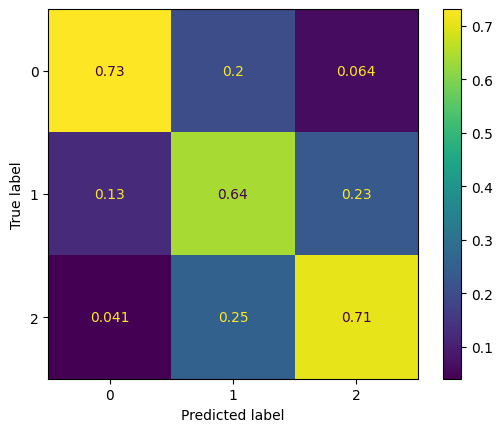

In [61]:
print(classification_report(y_train_unbalanced, y_pred_brf_cross_val))
ConfusionMatrixDisplay(confusion_matrix(y_train_unbalanced, y_pred_brf_cross_val, normalize='true')).plot()

### Generalization Performance

In [62]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']

transformer_random_forest = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'), ord_cols + categorical_unordered),
], remainder='passthrough')

brf_pipeline_test= Pipeline(steps=[
    ('transformer', transformer_random_forest),
    ('classifier', BalancedRandomForestClassifier(
        max_depth=20,
        min_samples_leaf=1,
        n_estimators=1000,
        replacement=True,
        sampling_strategy='all',
        random_state=42,  
        n_jobs=-1
    ))
])

In [63]:
brf_pipeline_test.fit(X_train_unbalanced, y_train_unbalanced)

,steps,"[('transformer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [64]:
y_pred_brf_test = brf_pipeline_test.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     51051
           1       0.62      0.63      0.63     39476
           2       0.47      0.70      0.56     17440

    accuracy                           0.68    107967
   macro avg       0.66      0.68      0.66    107967
weighted avg       0.72      0.68      0.69    107967



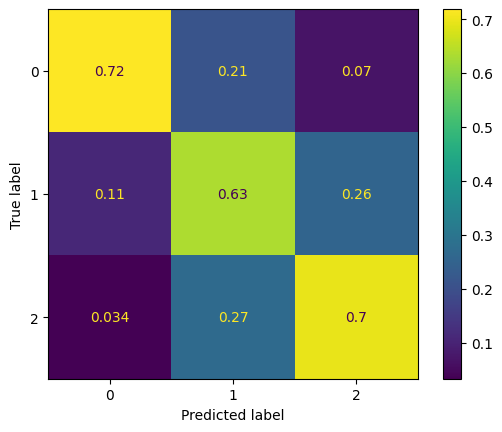

In [65]:
print(classification_report(y_test, y_pred_brf_test))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_brf_test, normalize='true')).plot()

## CatBoostClassifier

### Hyperparameter Tuning

In [ ]:
cat_idx = [i for i, (col, dt) in enumerate(X_train.dtypes.items())
           if isinstance(dt, pd.CategoricalDtype)]

classifier_cat = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=0,
)

bayes_search_space_cat_boosting = {
    'iterations': Integer(1000, 5000),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'depth': Integer(4, 10),
    'l2_leaf_reg': Real(1e-2, 10, prior='log-uniform'),
    'border_count': Integer(32, 255),
}

search_cat_boosting = BayesSearchCV(
    estimator=classifier_cat,
    search_spaces=bayes_search_space_cat_boosting,
    n_iter=30,          # Bayesian optimization iterations
    n_points=1,         # 1 points evaluated in parallel
    scoring='f1_macro',
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42,
)

search_cat_boosting.fit(X_train_rebalanced, y_train_rebalanced)
output_report('CatBoost', search_cat_boosting.best_score_, search_cat_boosting.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [ ]:
# New Results
# Report: CatBoost
# Best F1_Makro: 0.6956817837719443
# Best Params: OrderedDict({'border_count': 255, 'depth': 10, 'iterations': 4139, 'l2_leaf_reg': 0.18865998362606232, 'learning_rate': 0.01})

In [ ]:
# Report: CatBoost
# Best F1_Makro: 0.6813374990658295
# Best Params: OrderedDict({'classifier__border_count': 32, 'classifier__depth': 10, 'classifier__iterations': 5000, 'classifier__l2_leaf_reg': 0.01, 'classifier__learning_rate': 0.019411247872793094, 'classifier__loss_function': 'MultiClassOneVsAll'})

### Cross Validation Score

#### Old Score

In [66]:
cat_classifier_cross_val = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=0,
    border_count=32,
    depth=10,
    iterations=5000,
    l2_leaf_reg=0.01,
    learning_rate=0.019411247872793094
)

In [67]:
y_pred_cat_cross_val = cross_val_predict(cat_classifier_cross_val, X_train_rebalanced, y_train_rebalanced, cv=cv)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     53605
           1       0.59      0.59      0.59     53605
           2       0.69      0.74      0.71     53605

    accuracy                           0.69    160815
   macro avg       0.69      0.69      0.69    160815
weighted avg       0.69      0.69      0.69    160815



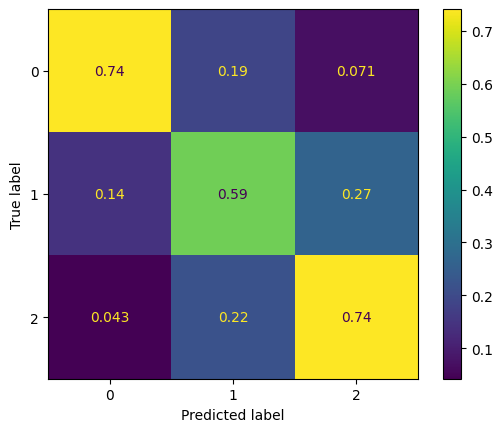

In [68]:
print(classification_report(y_train_rebalanced, y_pred_cat_cross_val))
ConfusionMatrixDisplay(confusion_matrix(y_train_rebalanced, y_pred_cat_cross_val, normalize='true')).plot()

#### New Score

In [69]:
# Best Params: OrderedDict({'border_count': 255, 'depth': 10, 'iterations': 4139, 'l2_leaf_reg': 0.18865998362606232, 'learning_rate': 0.01})

cat_classifier_cross_val2 = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=0,
    border_count=255,
    depth=10,
    iterations=4139,
    l2_leaf_reg=0.18865998362606232,
    learning_rate=0.01
)

In [70]:
y_pred_cat_cross_val2 = cross_val_predict(cat_classifier_cross_val2, X_train_rebalanced, y_train_rebalanced, cv=cv)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77     53605
           1       0.60      0.60      0.60     53605
           2       0.69      0.75      0.72     53605

    accuracy                           0.69    160815
   macro avg       0.70      0.69      0.70    160815
weighted avg       0.70      0.69      0.70    160815



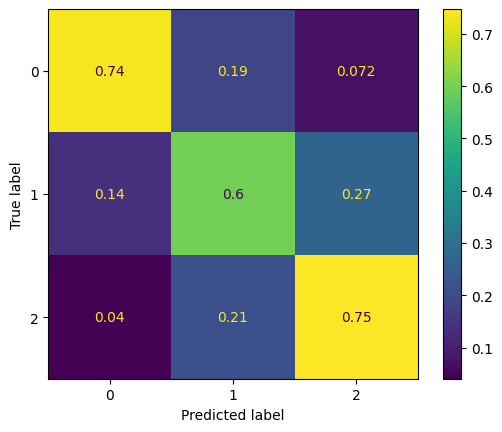

In [71]:
print(classification_report(y_train_rebalanced, y_pred_cat_cross_val2))
ConfusionMatrixDisplay(confusion_matrix(y_train_rebalanced, y_pred_cat_cross_val2, normalize='true')).plot()

### Generalization Performance

In [72]:
# Best Params: OrderedDict({'border_count': 255, 'depth': 10, 'iterations': 4139, 'l2_leaf_reg': 0.18865998362606232, 'learning_rate': 0.01})

cat_classifier_test = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=0,
    border_count=255,
    depth=10,
    iterations=4139,
    l2_leaf_reg=0.18865998362606232,
    learning_rate=0.01
)

In [73]:
cat_classifier_test.fit(X_train_rebalanced, y_train_rebalanced)

In [74]:
y_pred_cat_test = cat_classifier_test.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.73      0.80     51051
           1       0.63      0.60      0.62     39476
           2       0.46      0.73      0.57     17440

    accuracy                           0.68    107967
   macro avg       0.66      0.69      0.66    107967
weighted avg       0.72      0.68      0.69    107967



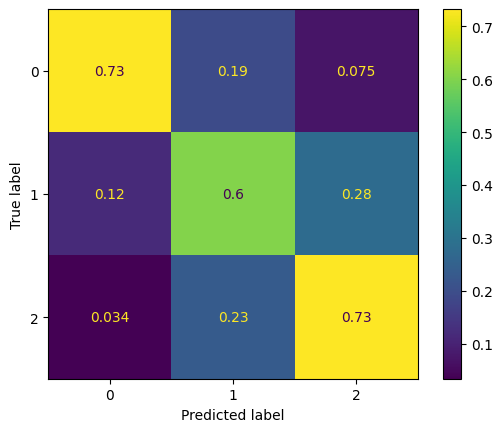

In [75]:
print(classification_report(y_test, y_pred_cat_test))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cat_test, normalize='true')).plot()

# Not Included: Please ignore

## HistGradientBoostingClassifier

In [ ]:
# Best params: {'min_samples_leaf': 80, 'max_leaf_nodes': 63, 'max_iter': 700, 'max_depth': 6, 'learning_rate': np.float64(0.05352681822847106), 'l2_regularization': np.float64(27.825594022071257), 'early_stopping': 'auto'}

hist_classifier = HistGradientBoostingClassifier(
    # categorical_features=cat_idx, # Use the native categorical support instead.
    early_stopping='auto', 
    scoring='f1_macro',
    min_samples_leaf=80,
    max_leaf_nodes=63,
    max_iter=700,
    max_depth=6,
    learning_rate=0.05352681822847106,
    l2_regularization=27.825594022071257
)

              precision    recall  f1-score   support

           0       0.88      0.72      0.79     51051
           1       0.62      0.60      0.61     39476
           2       0.45      0.73      0.56     17440

    accuracy                           0.68    107967
   macro avg       0.65      0.69      0.66    107967
weighted avg       0.72      0.68      0.69    107967



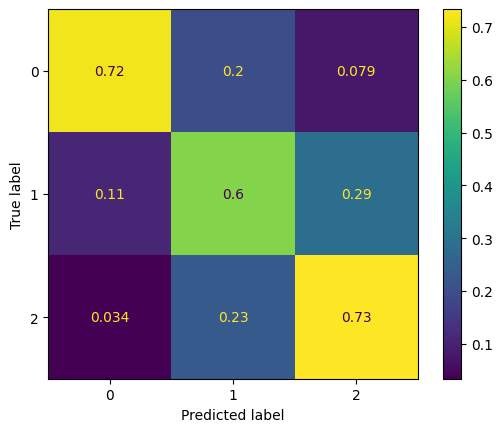

In [ ]:
hist_classifier.fit(X_train_rebalanced, y_train_rebalanced)

y_pred = hist_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

In [ ]:
pipeline_hist_boosting.fit(X_train, y_train)

y_pred = pipeline_hist_boosting.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81     51051
           1       0.62      0.72      0.67     39476
           2       0.60      0.45      0.52     17440

    accuracy                           0.71    107967
   macro avg       0.68      0.66      0.66    107967
weighted avg       0.71      0.71      0.71    107967



In [ ]:
bayes_search_space_hist_boosting = {
    'classifier__learning_rate': Real(0.001, 0.2, prior='log-uniform'),
    'classifier__max_depth': Categorical([None, 4, 6, 8]),
    'classifier__max_leaf_nodes': Integer(30, 200),
    'classifier__min_samples_leaf': Integer(20, 120),
    'classifier__l2_regularization': Real(1e-3, 2, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
    'classifier__class_weight': Categorical([None, 'balanced'])
}

# For expensive models, fewer CV folds to speed up
cv_fast = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

search_hist_boosting = BayesSearchCV(
    estimator=pipeline_hist_boosting,
    search_spaces=bayes_search_space_hist_boosting,
    n_iter=50,             # number of Bayesian optimization iterations
    n_points=5,            # 5 Different Points are evaluated in parallel
    scoring='f1_macro',
    cv=cv_fast,
    n_jobs=-1,             # parallelize across parameter settings
    verbose=1,
    random_state=42,
)

search_hist_boosting.fit(X_train, y_train)
display(search_hist_boosting)
output_report('HistGradientBoosting', search_hist_boosting.best_score_, search_hist_boosting.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


,estimator,Pipeline(step...'f1_macro'))])
,search_spaces,"{'classifier__class_weight': Categorical(c...), prior=None), 'classifier__l2_regularization': Real(low=0.00...m='normalize'), 'classifier__learning_rate': Real(low=0.00...m='normalize'), 'classifier__max_depth': Categorical(c...), prior=None), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'f1_macro'
,fit_params,None
,n_jobs,-1
,n_points,5
,iid,'deprecated'
,refit,True
,cv,StratifiedKFo... shuffle=True)


Report: HistGradientBoosting
Best F1_Makro: 0.6766894584255999
Best Params: OrderedDict({'classifier__class_weight': None, 'classifier__l2_regularization': 2.0, 'classifier__learning_rate': 0.049672282265936826, 'classifier__max_depth': None, 'classifier__max_iter': 125, 'classifier__max_leaf_nodes': 200, 'classifier__min_samples_leaf': 20})


In [ ]:
# Report: HistGradientBoosting
# Best F1_Makro: 0.6755804637821107
# Best Params: OrderedDict({'classifier__class_weight': None, 'classifier__l2_regularization': 2.0, 'classifier__learning_rate': 0.060056421102828716, 'classifier__max_depth': None, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 200, 'classifier__min_samples_leaf': 120})

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     51051
           1       0.62      0.71      0.66     39476
           2       0.60      0.46      0.52     17440

    accuracy                           0.71    107967
   macro avg       0.68      0.66      0.67    107967
weighted avg       0.71      0.71      0.71    107967



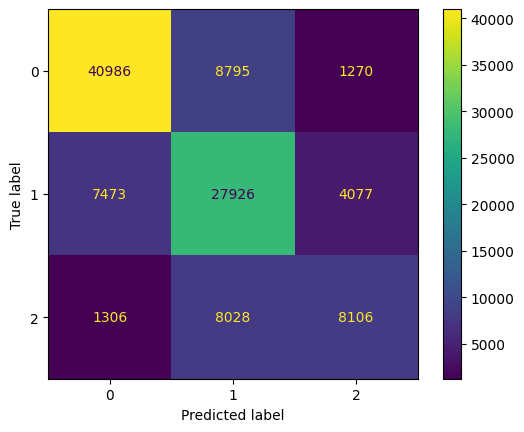

In [ ]:
y_pred = search_hist_boosting.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


In [ ]:
# Save the fitted search object (includes best estimator, cv results, etc.)
joblib.dump(
    search_hist_boosting.best_estimator_,
    './models/best_hist_gradient_boosting.joblib'
)

['./models/best_hist_gradient_boosting.joblib']

## Testing

In [21]:
# Stage 2: heavy (2) vs light (1) among injured
inj_mask = (y_train >= 1)
X_train_1_vs_2 = X_train[inj_mask]
y_train_1_vs_2 = y_train[inj_mask]

In [27]:
# names of columns that should be treated as categorical (same as old cat_idx definition)
cat_feature_names = [c for c in X_train.columns if c not in num_cols]

transformer_hist_boosting_test = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'),
     ['vehicle_category_simplified', 'vehicle_category_simplified_other', 'role']),
], remainder='passthrough')

from sklearn import set_config
set_config(transform_output="pandas")

# fit transformer once and get transformed train data as DataFrame
X_tr_hist = transformer_hist_boosting_test.fit_transform(X_train)

# map the *original* cat_feature_names to their positions in the transformed matrix
cat_idx = [i for i, col in enumerate(X_tr_hist.columns) if col in cat_feature_names]

pipeline_hist_boosting_test = Pipeline(steps=[
    ('transformer', transformer_hist_boosting_test),
    ('classifier', HistGradientBoostingClassifier(
        categorical_features=cat_idx,
        early_stopping='auto',
        scoring='f1_macro',
        class_weight='balanced'
    )),
])

In [28]:
bayes_search_space_hist_boosting_test = {
    'classifier__learning_rate': Real(0.005, 0.2, prior='log-uniform'),
    'classifier__max_depth': Categorical([None, 4, 6, 8]),
    'classifier__max_leaf_nodes': Integer(31, 127),
    'classifier__min_samples_leaf': Integer(20, 120),
    'classifier__l2_regularization': Real(1e-3, 100, prior='log-uniform'),
    'classifier__max_iter': Integer(400, 1000),
}

# For expensive models, fewer CV folds to speed up
cv_fast = StratifiedKFold(n_splits=3, random_state=50, shuffle=True)

search_hist_boosting_test = BayesSearchCV(
    estimator=pipeline_hist_boosting_test,
    search_spaces=bayes_search_space_hist_boosting_test,
    n_iter=50,             # number of Bayesian optimization iterations
    n_points=5,            # 5 Different Points are evaluated in parallel
    scoring='f1_macro',
    cv=cv_fast,
    n_jobs=-1,             # parallelize across parameter settings
    verbose=1,
    random_state=42,
)

search_hist_boosting_test.fit(X_train_1_vs_2, y_train_1_vs_2)
display(search_hist_boosting_test)
output_report('HistGradientBoosting', search_hist_boosting_test.best_score_, search_hist_boosting_test.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


,estimator,Pipeline(step...'f1_macro'))])
,search_spaces,"{'classifier__l2_regularization': Real(low=0.00...m='normalize'), 'classifier__learning_rate': Real(low=0.00...m='normalize'), 'classifier__max_depth': Categorical(c...), prior=None), 'classifier__max_iter': Integer(low=4...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'f1_macro'
,fit_params,None
,n_jobs,-1
,n_points,5
,iid,'deprecated'
,refit,True
,cv,StratifiedKFo... shuffle=True)


Report: HistGradientBoosting
Best F1_Makro: 0.7111293084780784
Best Params: OrderedDict({'classifier__l2_regularization': 100.0, 'classifier__learning_rate': 0.1862303061256768, 'classifier__max_depth': None, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 101, 'classifier__min_samples_leaf': 20})


In [ ]:
#Best Params: OrderedDict({'classifier__l2_regularization': 100.0, 'classifier__learning_rate': 0.1862303061256768, 'classifier__max_depth': None, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 101, 'classifier__min_samples_leaf': 20})

Hierarchical thresholds t1(injury)=0.42, t2(heavy)=0.58, weighted score=0.648
Raw hierarchical (argmax) macro F1: 0.6629940547462195
Tuned hierarchical macro F1: 0.6741184399962465
              precision    recall  f1-score   support

           0       0.88      0.74      0.80     51051
           1       0.62      0.70      0.66     39476
           2       0.52      0.62      0.56     17440

    accuracy                           0.70    107967
   macro avg       0.67      0.68      0.67    107967
weighted avg       0.73      0.70      0.71    107967



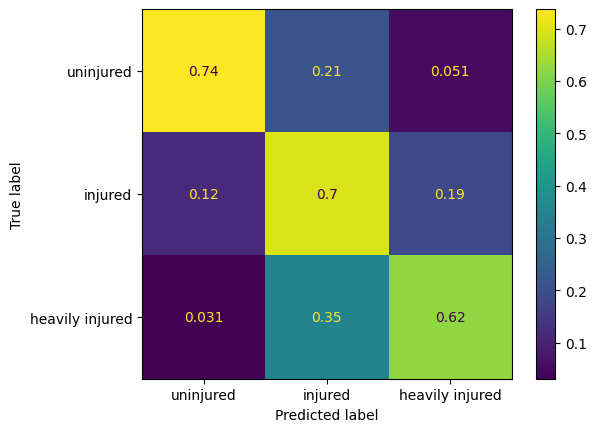

In [30]:
# Hierarchical two-stage model: (0 vs 1+2) then (1 vs 2)
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Transformer (ordinal encode categorical, pass numeric)
hier_transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr_full = hier_transformer.fit_transform(X_train)
X_te_full = hier_transformer.transform(X_test)
cat_idx_hier = list(range(len(cat_cols)))

# Stage 1: any injury (1 or 2) vs none (0)
y_stage1 = (y_train >= 1).astype(int)
sw1 = compute_sample_weight(class_weight='balanced', y=y_stage1)

# Best params from above: {'min_samples_leaf': 80, 'max_leaf_nodes': 63, 'max_iter': 700, 'max_depth': 6, 'learning_rate': np.float64(0.05352681822847106), 'l2_regularization': np.float64(27.825594022071257), 'early_stopping': 'auto'}

stage1_clf = HistGradientBoostingClassifier(
    categorical_features=cat_idx_hier,
    learning_rate=0.05352681822847106,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=63,
    l2_regularization=27.825594022071257,
    random_state=42
)
stage1_clf.fit(X_tr_full, y_stage1, sample_weight=sw1)

# Stage 2: heavy (2) vs light (1) among injured
inj_mask = (y_train >= 1)
X_tr_inj = X_tr_full[inj_mask]
y_stage2 = (y_train[inj_mask] == 2).astype(int)
sw2 = compute_sample_weight(class_weight='balanced', y=y_stage2)


#Best Params: OrderedDict({'classifier__l2_regularization': 100.0, 'classifier__learning_rate': 0.1862303061256768, 'classifier__max_depth': None, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 101, 'classifier__min_samples_leaf': 20})

stage2_clf = HistGradientBoostingClassifier(
    categorical_features=cat_idx_hier,
    learning_rate=0.1862303061256768,
    max_leaf_nodes=101,
    max_iter=1000,
    min_samples_leaf=20,
    l2_regularization=100,
    random_state=42
)
stage2_clf.fit(X_tr_inj, y_stage2, sample_weight=sw2)

# Predict probabilities
p_inj = stage1_clf.predict_proba(X_te_full)[:, 1]          # P(y>=1)
p_heavy_cond = stage2_clf.predict_proba(X_te_full)[:, 1]   # Approx P(y=2 | y>=1) (used on all for simplicity)

# Combine hierarchically
p2 = p_inj * p_heavy_cond
p0 = 1.0 - p_inj
p1 = p_inj - p2
probs = np.c_[p0, p1, p2]
probs = np.clip(probs, 0, 1)
probs = probs / probs.sum(axis=1, keepdims=True)

# Raw argmax prediction
y_pred_raw = np.argmax(probs, axis=1)

# Threshold tuning (t1 for injury, t2 for heavy) to boost classes 1 & 2
def predict_with_thresholds(p_inj, p_heavy, t1, t2):
    out = np.zeros_like(p_inj, dtype=int)
    inj_mask = p_inj >= t1
    heavy_mask = (p_heavy >= t2) & inj_mask
    out[inj_mask] = 1
    out[heavy_mask] = 2
    return out

def tune_thresholds_weighted(y_true, p_inj, p_heavy, g1, g2, weights=(0.2, 0.4, 0.4)):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 > 1 or t1 > 1: continue
            y_hat = predict_with_thresholds(p_inj, p_heavy, t1, t2)
            # Per-class F1
            f1_0 = f1_score(y_true == 0, y_hat == 0)
            f1_1 = f1_score(y_true == 1, y_hat == 1)
            f1_2 = f1_score(y_true == 2, y_hat == 2)
            score = weights[0]*f1_0 + weights[1]*f1_1 + weights[2]*f1_2
            # Ensure minimum recall for class 2
            cm = confusion_matrix(y_true, y_hat, labels=[0,1,2])
            recall_2 = cm[2,2] / cm[2].sum() if cm[2].sum() else 0
            if recall_2 < 0.5:
                continue
            if score > best[0]:
                best = (score, (t1, t2))
    return best

g1 = np.arange(0.3, 0.85, 0.02)   # injury threshold grid
g2 = np.arange(0.3, 0.85, 0.02)   # heavy threshold grid
best_score, (best_t1, best_t2) = tune_thresholds_weighted(y_test.values, p_inj, p_heavy_cond, g1, g2)

y_pred_hier = predict_with_thresholds(p_inj, p_heavy_cond, best_t1, best_t2)

print(f"Hierarchical thresholds t1(injury)={best_t1:.2f}, t2(heavy)={best_t2:.2f}, weighted score={best_score:.3f}")
print("Raw hierarchical (argmax) macro F1:", f1_score(y_test, y_pred_raw, average='macro'))
print("Tuned hierarchical macro F1:", f1_score(y_test, y_pred_hier, average='macro'))

print(classification_report(y_test, y_pred_hier))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_hier, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()